In [141]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, Callback
import tensorflow.keras
from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
import threading
from time import sleep

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()



In [178]:
datadict = {'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[]}
datadicttest = {'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[]}
length = 100
def makeData(filename):
    data = open(filename,'r')

    for line in data.readlines():
        line = line.rstrip()
        label = line[0]
        nums = eval(line[2:])
        lenth = len(nums)
        if lenth < length:
            nums = nums + [(0,0)]*(length-lenth)
            
        else:
            newlist = []
            n = lenth % length
            if n >= length/2:
                nums = nums + [(0,0)]*(length-n)
            indices = np.arange(0,lenth,lenth/length)
            indices = list(np.around(indices).astype(np.uint8))
            for i in indices:
                if len(newlist)<length:
                    newlist.append(nums[i])
            nums = newlist
        if filename == 'train.txt':
            datadict[label].append(nums)
        else:
            datadicttest[label].append(nums)
    data.close()
    


def visualizeData():
  font = cv2.FONT_HERSHEY_SIMPLEX
  row, col = 0,0
  fig, axs = plt.subplots(20, 10)
  fig.set_figheight(20)
  fig.set_figwidth(20)
  for label in datadict.keys():
    plot_list = np.random.choice(np.arange(0,len(datadict[label])), 20, replace = False)
    #print(len(plot_list))
    row = 0
    for lst in plot_list:
      img = np.zeros((512,512), np.uint8)
      for num in datadict[label][lst]:
          try:
              cv2.circle(img,num,5,(255),-1)
          except:
              pass
      #print(row,col)
      axs[row,col].imshow(img, cmap = 'binary')
      row += 1
    col += 1
        

makeData('train.txt')
makeData('test.txt')
#visualizeData()

#*************Custom Generator for Training Data************************#
    
def train_generator(batch_size =64):
    global startInt_train
    while True:
        X = []
        Y = []
        for i in range(batch_size):
            randomlabel = np.random.choice(list(datadict.keys()))
            randomindex = np.random.randint(0,len(datadict[randomlabel]))
            arr = np.array(datadict[randomlabel][randomindex])
            arr=arr.reshape(-1,2)
            arr = scaler.fit_transform(arr)
            X.append(arr)
            Y.append(randomlabel.astype(np.uint8))
        Y = np.array(Y)
        batchY = np.zeros((Y.size, 10))
        batchY[np.arange(Y.size),Y] = 1
        batchX = np.array(X)
        batchX = batchX.reshape(batch_size,length,2)
        batchY = batchY.reshape(batch_size,10)
        yield( batchX,batchY)
          
#*************Custom Generator for Testing Data************************#
'''
def validation_generator(batch_size = 64):
    global startInt_test
    while True:
        X = []
        Y = []
        for i in range(batch_size):
            randomlabel = np.random.choice(list(datadicttest.keys()))
            randomindex = np.random.randint(0,len(datadicttest[randomlabel]))
            arr = np.array(datadicttest[randomlabel][randomindex])
            arr=arr.reshape(-1,2)
            arr = scaler.fit_transform(arr)
            X.append(arr)
            Y.append(randomlabel.astype(np.uint8))
        Y = np.array(Y)
        batchY = np.zeros((Y.size, 10))
        batchY[np.arange(Y.size),Y] = 1
        batchX = np.array(X)
        batchX = batchX.reshape(10,length,2)
        batchY = batchY.reshape(10,10)
        yield( batchX,batchY)
'''
def validation_generator():
  X = []
  Y = []
  labels = list(datadicttest.keys())
  for i in labels:
    for j in range(len(datadicttest[i])):
      arr = np.array(datadicttest[i][j])
      arr=arr.reshape(-1,2)
      arr = scaler.fit_transform(arr)
      X.append(arr)
      Y.append(int(i))
  Y = np.array(Y)
  batchY = np.zeros((Y.size, 10))
  batchY[np.arange(Y.size),Y] = 1
  batchX = np.array(X)
  batchX = batchX.reshape(-1,length,2)
  batchY = batchY.reshape(-1,10)
  return(batchX,batchY)
  '''
  while True:
  
    X = []
    Y = []
    labels = list(datadicttest.keys())
    for i in labels:
      for j in range(len(datadicttest[i])):
        arr = np.array(datadicttest[i][j])
        arr=arr.reshape(-1,2)
        #print("shape: ", arr.shape)
        arr = scaler.fit_transform(arr)
        X.append(arr)
        Y.append(int(i))
    Y = np.array(Y)
    batchY = np.zeros((Y.size, 10))
    batchY[np.arange(Y.size),Y] = 1
    batchX = np.array(X)
    batchX = batchX.reshape(-1,length,2)
    batchY = batchY.reshape(-1,10)
    yield(batchX,batchY)
  '''

def get_test_data(s = True):
  X = []
  Y = []
  labels = list(datadicttest.keys())
  for i in labels:
    for j in range(len(datadicttest[i])):
      arr = np.array(datadicttest[i][j])
      arr=arr.reshape(-1,2)
      if s:
        arr = scaler.fit_transform(arr)
      X.append(arr)
      Y.append(int(i))
  Y = np.array(Y)
  batchY = np.zeros((Y.size, 10))
  batchY[np.arange(Y.size),Y] = 1
  batchX = np.array(X)
  batchX = batchX.reshape(-1,length,2)
  batchY = batchY.reshape(-1,10)
  return(batchX,Y)

In [186]:
v = validation_generator()

In [188]:
b1,b2 = v
b1.shape

(226, 100, 2)

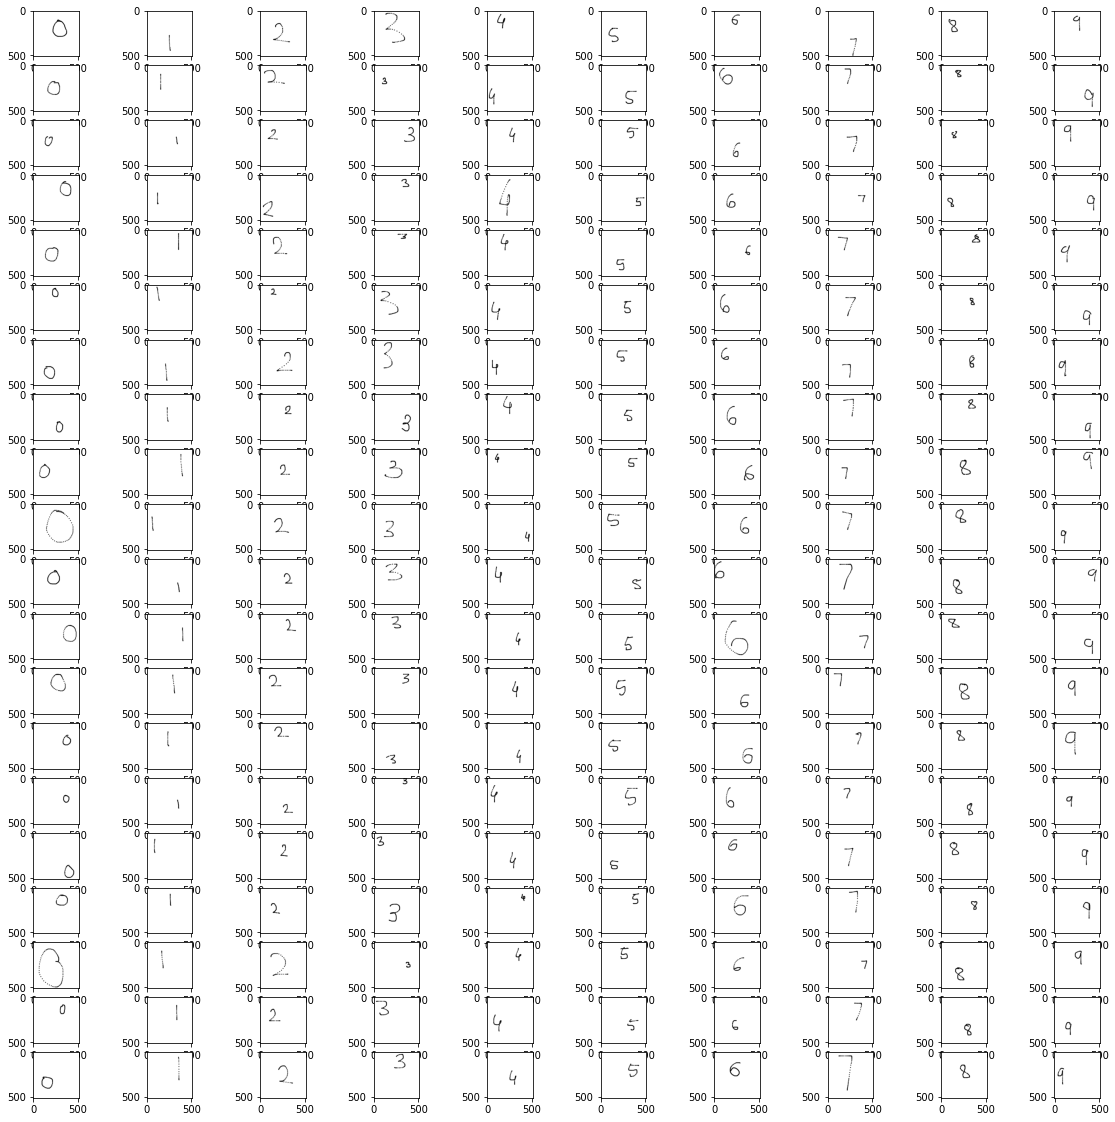

In [104]:
visualizeData()

In [117]:
x,y = get_test_data()
print(x.shape,y.shape)

(226, 100, 2) (226,)


In [142]:
#Model Parameters
n_neurons = 128
n_batch = 64
n_epoch = 100
steps_per_epoch = 100
checkpoint = ModelCheckpoint("ocrtestv9.h5", monitor='val_acc', verbose=1, save_best_only= False, save_weights_only=False, mode='auto', period=5)
#model = load_model('ocrtestv6.h5')

model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 2),return_sequences= True,stateful = False))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(n_neurons, input_shape=(length, 2),return_sequences= False,stateful = False))
model.add(BatchNormalization())
model.add(Dense(128,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10,activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = 'accuracy')
print(model.summary())
#
#


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100, 128)          67072     
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 128)          512       
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)             

In [175]:
model.fit_generator(
train_generator(),
verbose = 1,
steps_per_epoch = steps_per_epoch,
epochs = n_epoch,
validation_data = validation_generator(),
validation_steps = 1,
callbacks = [checkpoint])

NameError: ignored

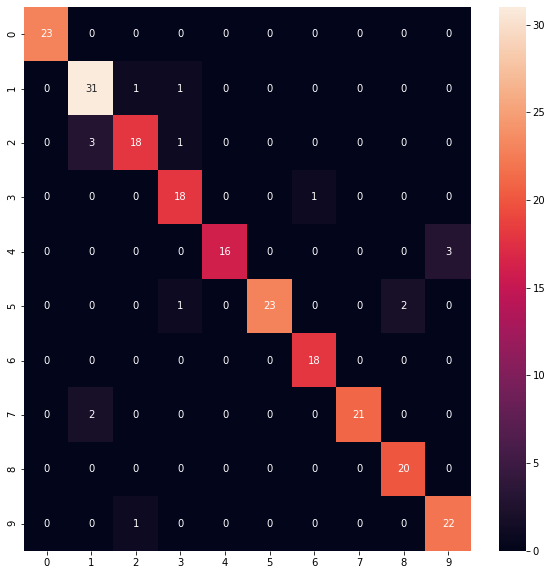

In [154]:
ypred = model.predict(x)
ypred = np.argmax(ypred, axis = 1)
cm = confusion_matrix(y,ypred)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = [10,10])
sns.heatmap(cm, annot=True)


In [155]:
from sklearn.metrics import classification_report
print(classification_report(y,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.86      0.94      0.90        33
           2       0.90      0.82      0.86        22
           3       0.86      0.95      0.90        19
           4       1.00      0.84      0.91        19
           5       1.00      0.88      0.94        26
           6       0.95      1.00      0.97        18
           7       1.00      0.91      0.95        23
           8       0.91      1.00      0.95        20
           9       0.88      0.96      0.92        23

    accuracy                           0.93       226
   macro avg       0.94      0.93      0.93       226
weighted avg       0.93      0.93      0.93       226



In [156]:
X_test,y = get_test_data(s = False)
ind = np.where(ypred != y)[0]
print(ind)
wrong_pred_x = X_test[ind]
wrong_pred_x.shape

[ 36  38  60  63  74  77  92 101 113 114 116 123 132 168 170 210]


(16, 100, 2)

In [157]:
print(y[ind])
print(ypred[ind])

[1 1 2 2 2 2 3 4 4 4 5 5 5 7 7 9]
[3 2 1 3 1 1 6 9 9 9 8 3 8 1 1 2]


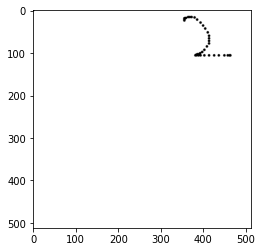

In [161]:

img = np.zeros((512,512), np.uint8)
for num in wrong_pred_x[2]:
  #print(num)
  cv2.circle(img,tuple(num),3,(255),-1)
#print(row,col)
plt.imshow(img, cmap = 'binary')

In [149]:
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()



In [190]:
#Model Parameters
n_neurons = 128
n_batch = 64
n_epoch = 100
steps_per_epoch = 100
checkpoint = ModelCheckpoint("ocrtestv9.h5", monitor='val_acc', verbose=1, save_best_only= False, save_weights_only=False, mode='auto', period=5)
#model = load_model('ocrtestv6.h5')

model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 2),return_sequences= True,stateful = False))
model.add(attention())
model.add(BatchNormalization())
model.add(Dense(128,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10,activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = 'accuracy')
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 100, 128)          67072     
_________________________________________________________________
attention_6 (attention)      (None, 128)               228       
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dense_63 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)             

In [191]:
model.fit_generator(
train_generator(),
verbose = 1,
steps_per_epoch = steps_per_epoch,
epochs = n_epoch,
validation_data = validation_generator(),
validation_steps = 1,
callbacks = [checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 11s 84ms/step - loss: 1.5766 - accuracy: 0.4864 - val_loss: 2.4316 - val_accuracy: 0.0973
Epoch 2/100
100/100 [==============================] - 8s 82ms/step - loss: 0.6751 - accuracy: 0.7584 - val_loss: 2.6521 - val_accuracy: 0.0973
Epoch 3/100
100/100 [==============================] - 8s 78ms/step - loss: 0.4567 - accuracy: 0.8452 - val_loss: 2.7303 - val_accuracy: 0.1018
Epoch 4/100
100/100 [==============================] - 8s 79ms/step - loss: 0.3396 - accuracy: 0.8875 - val_loss: 2.7849 - val_accuracy: 0.1858
Epoch 5/100
100/100 [==============================] - 8s 78ms/step - loss: 0.2495 - accuracy: 0.9187 - val_loss: 1.9896 - val_accuracy: 0.3142

Epoch 00005: saving model to ocrtestv9.h5
Epoch 6/100
100/100 [==============================] - 8s 81ms/step - loss: 0.2053 - accuracy: 0.9303 - val_loss: 0.7799 - val_accuracy: 0.7301
Epoch 7/100
100/100 [==============================] - 8s 80ms/step - loss: 0.1893 - accurac

KeyboardInterrupt: ignored

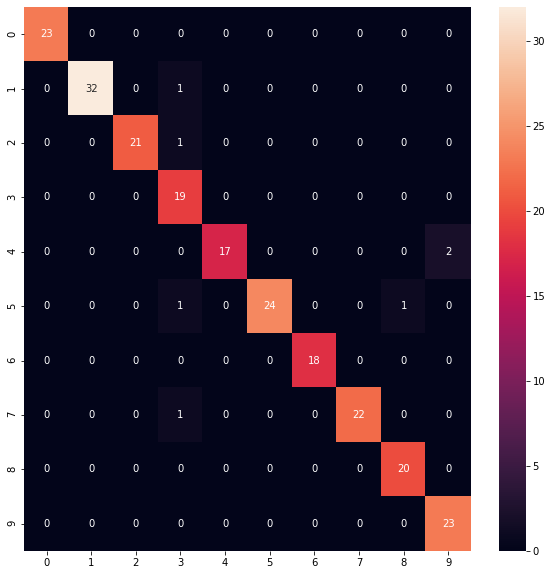

In [192]:
ypred = model.predict(x)
ypred = np.argmax(ypred, axis = 1)
cm = confusion_matrix(y,ypred)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = [10,10])
sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      0.97      0.98        33
           2       1.00      0.95      0.98        22
           3       0.83      1.00      0.90        19
           4       1.00      0.89      0.94        19
           5       1.00      0.92      0.96        26
           6       1.00      1.00      1.00        18
           7       1.00      0.96      0.98        23
           8       0.95      1.00      0.98        20
           9       0.92      1.00      0.96        23

    accuracy                           0.97       226
   macro avg       0.97      0.97      0.97       226
weighted avg       0.97      0.97      0.97       226

[1 2 4 4 5 5 7]
[3 3 9 9 8 3 3]


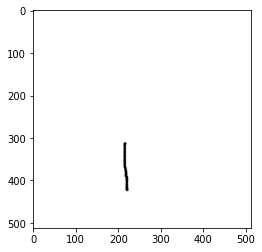

In [195]:
from sklearn.metrics import classification_report
print(classification_report(y,ypred))
X_test,y = get_test_data(s = False)
ind = np.where(ypred != y)[0]
wrong_pred_x = X_test[ind]
img = np.zeros((512,512), np.uint8)
print(y[ind])
print(ypred[ind])
for num in wrong_pred_x[0]:
  #print(num)
  cv2.circle(img,tuple(num),3,(255),-1)
#print(row,col)
plt.imshow(img, cmap = 'binary')